## Numerical Methods

In [25]:
# import all python add-ons etc that will be needed later on
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from scipy.integrate import quad,odeint
from scipy.optimize import fsolve
init_printing()                      # allows printing of SymPy results in typeset maths format
plt.rcParams.update({'font.size': 16})  # set font size for plots

This chapter outlines several numerical techniques and associated algorithms which are needed to perform integrations and solve differential equations. These are written generically and with Python. Accurate and efficient ways of calculating results from theory is an essential tool for any scientist. Using computer algebra programs such as Sympy is a great boon because calculations can be done to great numerical precision and accuracy. However, in line with our objective of understanding the principles of how to solve problems, several techniques, which contain the essence of the method to be used, are outlined.

Once these are understood, you will have the knowledge to understand the more complex 'black-box' methods that Maple, SymPy, or other software use.
    
To start this chapter, some details on numerical accuracy are reviewed; next simple integration methods are described with a few examples and problems. More difficult, and interesting, is the numerical integration of differential equations, some of which only have numerical solutions. The various methods used are explained. A different numerical approach is taken in the next chapter on Monte Carlo methods. Simple integration is rather slow by this method but integrating differential equations is very robust. Monte Carlo methods are very versatile at simulating physical processes, such as diffusion or fluorescence, and occasionally this is the only way to do the calculation. Simulation also provides a good way to understand the processes involved, some of which can be very complex and not always easily translated into differential equations.


### 1.1 Rounding errors

In many calculations, the errors introduced by the computer due to the way its integers and real numbers are manipulated do not matter. Sometimes, the answer the computer returns may be precise and will be printed to many decimal places; however, it may not be accurate. To understand this, the expression $(1 - x)^6$ is expanded as the series $1-6x+15x^2 -20x^3 +15x4 -6x^5 +x^6$ and this is plotted close to its minimum at $x\approx 1$ in Fig.1. While the scale is small, $\approx 10^{-13}$, determining the exact root of the equation numerically is difficult. Of course, we know it is at $1$, but the computer will not give this answer even using a Newton-Raphson iterative scheme. The reason for the noisy plot is because the alternating positive and negative terms in the summation add up to almost zero, and the rounding error in the precision with which the numbers are calculated becomes important, and this limits the accuracy of the calculation.

A real number is converted in the computer into a floating-point number represented as $x = \pm 0.d_1d_2d_3d_4 \cdot 10^y$ which only approximately represents the number; i.e. it is only accurate to a certain number of decimal places. The mantissa, is the fraction $0.d_1d_2d_3d_4$, where $d_1$ etc. are the digits $0\cdots 9$. A floating-point number is usually described as a single or double precision and the number of decimal places is typically $7$ and $14$ respectively; this depends on the type of computer being used. Normally nowadays double precision is standard for example $17$ digits.

However, as seen in Fig. 1, 17 digits are not good enough to find the root; $25$ decimal places give a far more accurate result. The instruction Digits:= 25, sets $25$ decimal place precision for floating point numbers.
Using the Newton-Raphson method (see Chapter 3.10), the root cannot be found accurately: the method is 

In [26]:
f = lambda x:  1.0 -6.0*x +15*x**2 -20.0*x**3 +15.0*x**4 -6.0*x**5 +x**6
df= lambda x: -6.0 +30.0*x -60.0*x**2 +60.0*x**3 -30.0*x**4 +6.0*x**5      # derivative
s  = 0.8
for i in range(100):
    snew = s - f(s)/df(s)
    if abs(snew-s) < 1e-10:
        break
    else:
        s = snew
print(s)

1.0030182818841857


With typical double precision (16 decimal places), the root found is 1.0030182818841857, which is not even on the graph shown below, but furthermore it depends greatly on the starting value. If the function $(1 - x)^6$ is plotted directly without expanding, and hence without accumulating rounding errors, then the curve looks like that obtained with $25$ digits precision. This illustrates the important point that in many cases a small amount of algebra can significantly improve numerical calculations; errors rapidly accumulate with the repeated adding and subtracting of similarly sized numbers, and once an error is present it contaminates all subsequent results.

![Drawing](num-methods-fig1.png)

Figure 1. Plots of the series expansion of $(1 - x)^6$ with two different values of floating point precision. (Notice the axes range.)
_____

### 1.2 Truncation errors

In summing a series, the number of terms to be added has to be decided in advance. This automatically leads to an error that is nothing to do with arithmetical precision. The calculation should be repeated with more terms until the number of decimal places you require is continuously obtained. Rounding errors must additionally be considered, especially if the series contains alternating positive and negative terms; the errors can accumulate as the summation continues but will not be the same for all values of $x$.

Consider the series $ \displaystyle \sin(x)=1-\frac{x^3}{3!}+\frac{x^5}{5!}-\cdots$ which is valid for all $x$. If the series is summed up to the term $x^n/n!$ with $x \gt 0$, the error is less than $\displaystyle \left| \frac{x^{n+2}}{(n+2)!}\right|$. The values of $\sin(0.5)$ is $0.47942553$ whether calculated directly using Python or as the summation up to the $x^7$ term. If, however, $x$ is large, for instance $x = 5.5\pi$, then we know by drawing a graph that  $sin(x) = -1$, but by summation up to $x^7$ the result is $-79258.34$: clearly this is ridiculous because $\sin(x) \le 1 $ for all $x$. Only if the number of terms in the summation is increased to at least terms $\gt x^{59}$, and the numerical precision increased to $20$ decimal places can an accurate result be obtained from the series approach. In this instance, we know that the answer from the small summation is incorrect because the properties of $\sin(x)$ are well known, but if you are summing a series whose result is unknown, then great care is necessary.

### 1.3 Unstable recursion: magnification of errors

In solving integrals, a recursion formula can often be found, particularly when the integration is done by parts. An example met before (Q4.22) is

$$\displaystyle I_n=\int_0^1 x^ne^{x-1}dx = x^ne^{x-1} \bigg|_0^1 -n\int_0^1 x^{n-1}e^{x-1} dx =1-nI_{n-1}$$

To evaluate the integral with the code below different $n$, the starting value with $n = 0$ is required, which is $I_0 = 1 - 1/e$. In the recursion calculation, $s$ has, arbitrarily, been chosen as the name for the integral because $I$ and $int$ are reserved names in Sympy. Recall that $s= 1 - n* s$; is an assignment, meaning that the new value of $s$ is $1 - n \times (current\; value)$. Some of the results are tabulated below the code, $n$ is the power to which $x$ is raised, $s$ is the recursion answer and $f(n)$ the result of algebraic integration.  

In [27]:
x, n = symbols('x n',positive=True)                # use SymPy

s = 1.0 - 1.0/np.exp(1.0)            # initial value
print('{:s}'.format('n      s      f(n)'))
for n in range(1,23):
    s = 1.0 - n*s                    # recursion 
    eqn = x**n*exp(x-1)
    f = integrate(eqn,(x,0.0,1.0) )  # normal integration
    print('{:d} {:10.6g} {:s}'.format(n,s,str(f.evalf() )[0:8] ) )    # format output
    pass

n      s      f(n)
1   0.367879 0.367879
2   0.264241 0.264241
3   0.207277 0.207276
4   0.170893 0.170893
5   0.145533 0.145532
6   0.126802 0.126802
7   0.112384 0.112383
8   0.100932 0.100931
9  0.0916123 0.091612
10  0.0838771 0.083877
11  0.0773522 0.077352
12  0.0717732 0.071773
13  0.0669478 0.066947
14  0.0627311 0.062732
15  0.0590338 0.059020
16  0.0554593 0.055664
17  0.0571919 0.062500
18 -0.0294537 0
19    1.55962 -16.0000
20   -30.1924 0
21     635.04 16384.00
22   -13969.9 0


The failure of both the Sympy integration and the recursion formula indicates how careful one needs to be with some apparently innocent numerical calculations. After about $n = 10$ it is difficult to judge which calculation gives the most accurate result, and by $n = 18$, both are clearly wrong. If integer constants  are used then accurate results are obtained for the direct integration, but using integers will not always be an option. 

While this calculation is a little unusual, it is not uncommon. When calculating wavefunctions using Hermite or other polynomials, large powers of $x$, exponentials and recursion formulae are commonly used. Recursion and difference formulae are often used in the numerical integration of differential equations, see Section 11.3, consequently, their numerical integration is akin to an art rather than a science. However, you should not be too despondent or sceptical about numerical methods because with care, and sometimes cunning, accurate results can be obtained.

### 1.4 Organized Chaos

You need to be aware that recursion can sometimes lead to chaotic behaviour as a normal outcome of a calculation. This is a different sort of chaos to that just calculated; it is very much like 'organized chaos' and is not due to rounding or precision errors. Often this chaos is termed 'deterministic'. 

There is an important distinction therefore to be made between different types of 'Chaos'. In classical and quantum mechanics, in studying molecules for example, it is also observed that regular motion can suddenly become chaotic even though the underlying equations of motion do not indicate that this will necessarily happen. By 'chaotic' is meant that two starting conditions placed arbitrary close to one another in value, will lead to entirely different but _repeatable outcomes_ at some later time. If the cause of the chaos is due to rounding errors, the outcome is not repeatable but unpredictable.

We take a short diversion into this interesting topic via a well-known example of deterministic chaos, first described in detail by May (1974, 1987) and May & Oster (1976), and called the *logistic map*. This arises from the recursive equation 

$$x_{n+1} = rx_n(1 - x_n)$$

where $r$ is a constant and this equation is the discrete version of the logistic equation (Verhulst 1838) used to describe population growth, $dN/dt=rN(1-k/N)$ where $N$ is the population $r$ the growth rate and $k$ a constant the carrying capacity. This equation works well only for some species such as bacteria but not for other more complex ones. The reaction $A+X\leftrightharpoons 2X,\quad X+B\to C$ has the related rate equation $dX/dt=-(k_1A+k_2B)X+4k_2X^2$ if $[A],[B]$ are held constant.

Returning to the logistic map, if $x_{n+1}$ is plotted vs $x_n$  then it has an inverted parabola like shape, fig 1a, with a maximum at $r/4$. 

![Drawing](num-methods-fig1a.png)

Figure 1a. plot of the equation $x_{n+1} = rx_n(1 - x_n)$. 
__________

We shall call $x$ the population, $r$ the growth rate and $n$ number of iterations which could also be interpreted at discrete units of time. When the growth rate $r\lt 1$ the population decreases from its initial value $x_0$ to zero. Only above $r\ge 1$ does the population increase. As it does it rises rapidly, then oscillates before reaching a steady value.  However, at a value of $r\ge 3$ bifurcation occurs, i.e. the oscillations persist indefinitely, and two values are alternately produced. As $r$ increases a little more, two periods are seen and four values exist, and these double again as $r$ continues to increase until eventually chaos ensues at about $r = 3.9$. Above $ r = 4 $, $x_n$ becomes negative, thus the valid range is $ 0\lt r \le 4$. Figure 1b shows this behaviour with an initial value of $x_0 = 0.1$.

![Drawing](num-methods-fig1b.png) 

Figure 1b. The population $x_n$ shown vs. iteration number $n$ for different growth rates $r$. Notice that bifurcation occurs above $r=3$ and that chaotic behaviour at $r=3.9$. The data points are in red, the line simply aids the eye to help follow the pattern of the points.
_________

To be able to view the bifurcations more easily a plot of population $x_n$ vs $r$ is made and apparently random behaviour from otherwise regular behaviour is observed, Fig. 2. Some authors call this an orbit plot. The iteration is continued at each $r$ for at least a hundred steps to allow and initial oscillations to die out and become constant or to allow any constant oscillation to become steady or random depending on $r$. As $r$ increases the doubling multiplies to $4, 8, 16\cdots $ and more numerous sets of numbers produce a random looking but regular pattern.   Figure 2 shows part of the plot.   The values up to $r=1$ are zero then they rise uniformly in a single curved line to join the plot shown. The initial pitchfork bifurcation at $r=3$ is clear as are the next few bifurcations (at each of which the number of points double) at $r\approx 3.449, 3.5409, 3.5644\cdots $ but then become too numerous to see on this plot. Pain (1993, chapter 12) and Strogatz 1994 chapter 10) both describe these non-linear and chaotic effects that have been observed experimentally as well as a detailed mathematical description of this topic.

![Drawing](num-methods-fig2.png)

Figure 2. Bifurcations and ordered chaos generated by iterating $x_{n+1} = rx_n(1 - x_n)$.
____

The Feigenbaum constant $\delta=4.669301\cdots$ is the ratio of three successive birfurcation points and is a property of all maps of this type, not just the logistic map. The constant is $\displaystyle \delta =\lim_{n\to \infty}\frac{\mu_{n+1}-\mu_n}{\mu_{n+2}-\mu_{n+1}}$ where $n$ is the index of the birfucation and $\mu$ the value of $r$ at that point. Interestingly, any equation that shows an inverted curve, such as $x_{n+1}=r\sin(x_n)$, shows very similar behavior in all respects to that of the logistic map.

The code to do this calculation is

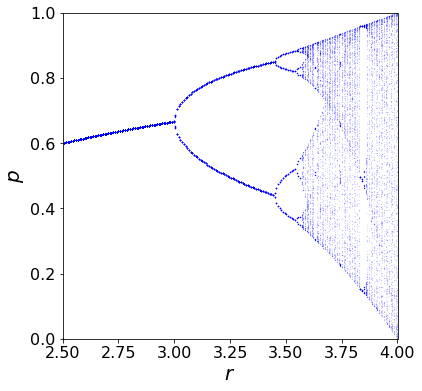

In [28]:
# Algorithm L:ogistic eqn. & Bifurcation 

fig1= plt.figure( figsize=(6,6) )
plt.rcParams.update({'font.size': 16})

Leqn = lambda r,x: r*x*(1.0-x)        # logistic map eqn

n = 200                               # increase this for more detail
dn= 200
m = n + dn
popl = np.zeros((n,n),dtype=float)    # define 2D array
popl[:,:] = 2                         # set value outside plot range
r0  = 2.5                             # r start
rmax= 4.0                             # r end   
r = np.linspace(r0,rmax,n)            # growth rate array

x = 0.0                               # initial x 
for j in range(n):
    for i in range(m):
        x = Leqn(r[j], x)             #        x = r*x*(1.0 - x)
        if i > n:
            popl[j,i-dn] = x          # save last n do this to get all branches as these oscillate
        pass
    x = x + 1.0/n                     # increment x
    pass

for i in range(n):
    plt.scatter(r[:],popl[:,i],marker='.',s = 0.01,color='blue')  # plot 
    
plt.xlim([r0,4])
plt.ylim([0,1])
plt.xlabel(r'$r$',fontsize=20)
plt.ylabel(r'$p$',fontsize=20)
plt.show()

## 2 Numerical methods used to find the roots of an equation

### Secant method

We now set aside the questions of numerical accuracy and chaos and look at some practical methods of numerically solving all sorts of equations. Sometimes in integration or in solving differential equations, the root of some function is required; three related numerical methods, the Secant, Regula Falsi, and bisection, are now described. The Newton - Raphson method has already been met in Chapter 3.10 and is used when the equation can be differentiated.

The secant method is similar in idea to the Newton - Raphson method except that the derivative is expressed as a difference equation. If $f (x) = 0$ is the equation whose roots or $x$ values we want to find, then, in a recursive scheme, the next $x$ value is given by Newton - Raphson as $x_{n+1} = x_n  f(x_n)/f'(x_n)$ with $n = 0, 1, 2 \cdots$ and $f'$ is the derivative with respect to $x$. Notice how similar this equation is to the general form of the logistic map in the previous section, i.e $x_{n+1}=f(x_n)$.  The $x_0$ value to start the calculation must be somewhere near to the root, and can be estimated by plotting the function. At the end of each step, the new value $x_{n+1}$ is substituted into the right-hand side of the equation, and the process is repeated until the absolute value of the function becomes less than some preset tolerance or the number of iterations is exceeded.
In the secant method, the derivative is approximated as

$$\displaystyle f'(x_n)\approx \frac{\Delta f}{\Delta x}=\frac{f(x_n)-f(x_{n-1})}{x_n-x_{n-1}}$$

then substituting into the Newton - Raphson equation gives

$$\displaystyle  x_{n+1} = x_n -f(x_n)\frac{x_n-x_{n-1}}{f(x_n)-f(x_{n-1})}  \tag{1}$$

which is the working equation for the secant method. Two initial guesses of the root are required, because the equation has to have points at $x_1$ and $x_2$ to begin the iterative process and these are usually to one side of the root. Once the method is close to a root, the number of digits of accuracy doubles for every two iterations. However, the method can sometimes fail because the particular curvature of the function may produce $f(x_n) = f(x_{n1})$. 

In each of the following three algorithms the new value $x_{n+1}$ is called $x_m$ and is given a dummy value greater than the tolerance to start with. The root and the value of the function at the root, which should be zero or very close to it, are printed. The equation is $x^5 + x = 1$. The three methods give essentially the same result if the tolerance on ending the calculation is similar.

In [29]:
# Algorithm; Secant method

f  = lambda x: x**5+x - 1      # function to solve
x1 = 0.0  
x2 = 0.5
xm = 2*x2
xtol=1e-8
while abs(f(xm))  > xtol:
    xm = x1 - f(x1)*(x2-x1)/(f(x2)-f(x1))
    x1 = x2
    x2 = xm
    pass
print('{:s} {:12.8f}'.format('root = ', xm)   )

root =    0.75487767


If the starting points span the root, then the false position or Regula Falsi method is used. This method uses the same equation as the secant method but a slightly different algorithm is used to generate the next point. This ensures that the root is always straddled. The algorithm is

In [30]:
# Algorithm; Regula Falsi

f  = lambda x: x**5+x-1
x1 = 0.0
x2 = 1.0
xm = 2*x2
xtol = 1e-8
while abs(f(xm))  > xtol:
    xm = x1-f(x1)*(x2-x1)/(f(x2)-f(x1))
    if f(x1) > f(x2) :
        x1 = xm
    else:
        x2 = xm
    pass
print('{:s} {:12.8f}'.format('root = ', xm)   )

root =    0.75487766


The bisection method is the simplest and most robust method. The initial estimates must span the root; therefore, the function is calculated from some point until its sign is changed, if the whereabouts of the root is unknown. At this point, the bisection method is repeatedly used to divide the region into finer parts.  The while loop is also limited by the number of iterations to prevent this becoming infinite. One 'trick' that can sometimes be used in the secant and Regula Falsi method, should they fail, is to add a small number, $\lt 10^{-6}$, to the denominator, to prevent it accidentally becoming zero.



In [31]:
# Algorithm; Bisection Method

f  = lambda x: x**5+x-1

def bisect(f,x1,x2):   
    xm   = 2*x2
    xtol = 1e-8
    n = 0
    while abs(f(xm))  > xtol and n < 40:    # limit loop to 40 times
        xm = (x2+x1)/2.0
        if f(x1)*f(xm) > 0:
            x1 = xm
        else:
            x2 = xm
        pass
        n = n + 1
    return xm

ans = bisect(f,0.0,1.0)    # call bisect with initial values 0 and 1
print('{:s}  {:12.8f}'.format('root = ', ans)   )

root =     0.75487766


## 3 Numerical integration
Two methods of numerical integration have been briefly described in other chapters, one is the series expansion of a function and then a numerical evaluation of the terms; the other is the Euler - Maclaurin formula Chapter 5.7 and care needs to be exercised with both these methods. Three general and simpler methods are now outlined; these are the mid-point, the trapezoid, and Simpson's rule. More sophisticated numerical methods than these are described in Numerical Recipes (Prest et al. 1986) and similar specialized texts.

Each of these methods divides the function to be integrated into small strips at predetermined abscissas, which are then multiplied by a certain constant number depending on the method, and added together. The integration becomes a summation, Fig. 3, and the general name for such a numerical integration method is *quadrature*. These methods are similar to the basic way we think about integration as the limiting area of a summation of rectangular strips as the width of each strip tends to zero. If the strips are fine enough, the result is a good approximation to the true value. In general, however, we do not initially know how many strips will be needed and some experimentation with this number is always necessary.

It should be remembered that whatever numerical method is used, a polynomial is being integrated and not the original equation, and thus the ability of this to describe the curve will affect the results. The more sophisticated the method becomes, the higher the order of the polynomial used.

![Drawing](num-methods-fig3.png)

Figure 3. The trapezoidal rule approximates an integral with straight lines between points $x_1,\, x_2,\, \cdots$, although not very well in this example, where the strips are too far apart to represent the function accurately. The mid-point method, on the other hand, evaluates the function half way between each point, three of which are shown by the vertical dotted lines.
______
### 3.1 Always try some algebra first
There is always a tendency when using numerical methods to submit the equation directly to the computer. In many cases, however, performing some algebra first will help. This might mean simplifying the equation, removing constants to outside the integration, and, in particular, substitution of variables, which is done in standard integration. Consider the integral $\displaystyle \int_0^\infty (1+x^2)^{-1}dx$ This converges very slowly and makes the upper limit very large, which results in a slow calculation and potentially inaccurate numerical result. In fact, due to rounding errors, the result will get worse as the numerical integration proceeds. Some values of $1/(1 + x^2)$ are given in Table 2 and show that the maximum $x$ in the integration has to be at least $100$ for four-figure accuracy. This means that at least $1000$ points have to be used in the integration and even possibly $10,000$.

What is needed is to transform the function into something less extended. The substitution $x = e^{uz} - 1$ where $u$ is a small constant will do this. Typically, $u = 5$, although this value is not critical. Differentiating $x = e^{uz} - 1$ gives $dx = ue^{uz}dz$, but the limits are still the same; $z = 0$ when $x = 0$ and $z = \infty$ when $x = \infty$. Making substitutions and simplifying a little makes the integral,

$$\displaystyle \int_o^\infty \frac{u}{2e^{-uz}+e^{uz}-2}dx$$

The upper limit is still $\infty$, but now this is not really important. If $z = 3$, the function in the integral has the value $\approx 1.5\cdot 10^{-6}$ making the whole expression virtually zero beyond this value, and so $3$ is the effective upper limit; quite an improvement on infinity. Additionally, fewer points in the integration are needed for the same precision.

Table 2. The slow convergence over a wide range of $x$
$$\displaystyle \begin{array}{ccc}
x & 0.01 & 0.1 & 1 & 10 & 100 \\[0.25cm]
\hline
1/(1+x^2) &0.9999000& 0.9900990&0.5 & 0.0099009& 0.000099\\
\end{array}$$

### 3.2 Mid-point rule integration

Mid-point integration assumes that the function is split equally into $N$ points, and any point is connected by a straight line to the next, thus ignoring any curvature between these points. Clearly, for a rapidly oscillating or varying function, many determinations of N will be needed to obtain an accurate answer. The mid-point method, not surprisingly, sums the values of the _function_ at the mid-point of each strip, $x_1^m \; x_2^m \cdots x_N^m $ as

$$\displaystyle I_m=\int_a^b f(x)dx \approx \frac{b-a}{N}[f(x_1^m)+f(x_2^m)+\cdots + f(x_N^m)]$$

and as $x_1^m = a+h/2,\; x_2^m = a+3h/2 \cdots x_N^m =a+(N+1)h/2$ in summation notation the equation is 

$$\displaystyle I_m=\int_a^b f(x)dx\approx \sum_{j=0}^{N-1} f(a+(j+1/2)h) \tag{2}$$

One advantage of this rule is that it enables functions with singularities in the integration range to be calculated. For instance, $1/(1 - x)$ is infinite at $x = 1$, but an integration spanning this point need not fail with the midpoint method but will do so with all other methods that calculate the function at integer increments of $h$.

The error in the integral calculated with the mid-point method is $\displaystyle \epsilon = \pm\frac{(b-a)^3f''(c)}{24N^2}$ and this will be greatly reduced by increasing the number of points $N$. The size of this error is found by calculating two points $c$ where the second derivative has its maximum and minimum in the range $a \le c \le b$, and choosing the largest absolute value. This can be the most difficult part of the calculation and is usually not worth the effort. It is easier to calculate the integral by doubling the number of points each time until a sufficient number of decimal places are unchanging in the result. The mid-point method is the simplest to calculate and gives accurate answers, yet it is hardly mentioned in textbooks compared to the two methods described next. Notice that, because the mid-points are used, there is one less point in the summation using the mid-point method than in the trapezoid or Simpson's method described next.

The mid point method is illustrated in the next algorithm where $e^{-x^2}$ is integrated from $0 \to 1$. The exact value is $0.74682$ and the numerical value is $0.74690$ which is close and only used $20$ points in the integration, however, To obtain $5$ decimal place accuracy more than $100$ terms are needed.

In [32]:
# Algorithm; mid point integration method writtten as a subroutine or def

#--------------------------
def mid_point(f,a,b,N):    # define routine
    h = (b-a)/N
    s = 0.0
    for j in range(N):              # last value is N-1, first 0
        s = s +h*f( a+(j+0.5)*h )
    return s
#---------------------------
f = lambda x: np.exp(-x**2)     # define function
a = 0.0
b = 1.0
n = 20
 
print('{:s} {:6.5f}'.format('sum = ', mid_point(f,a,b,n)) )

sum =  0.74690


### 3.3 Trapezoidal rule integration

Trapezoidal integration is also straightforward. The equation to approximate the
integral is

$$\displaystyle I_T=\int_a^b f(x)dx \approx \frac{b-a}{2N}\bigg(f(x_1)+2f(x_2)+2f(x_3)+\cdots + f(x_N)\bigg) \tag{3}$$

whereby the integration is again split into $N$ strips, Fig. 3, and $N$ must be an even number. Calculating points $x_1,\, x_2,\cdots$  is easily done because they are related to the gap between the points; $x_2 =x_1 +h,\,x_3 =x_1 +2h$ ,and so forth; see Fig.3, and $h=(b-a)/N$ is the width of one strip.

The integral can be calculated either, as in equation (3), by adding up the first and last value of $f$ and twice all the rest and then multiplying by $h/2$, or by adding up all the values of $f$ then subtracting half the value of the first and last points and finally multiplying the result by $h$. Usually, as with all numerical methods, the result is calculated with several increasing values of $N$ to see if convergence is achieved. The error $\epsilon$ indicates how many decimal places the result is accurate to and is reduced as $1/N^2$, the same as for the mid-point rule.

In [33]:
# Algorithm Trapezoid rule

f = lambda x: np.exp(-x**2)     # define function

a = 0.0
b = 1.0
N = 20
h = (b-a)/(N)
s = 0.0
for j in range(N+1):              # last value is N, first 0
    s = s + 2*f( a + j*h )
    
ss= h*(s -(f(a)+f(b))  )/2.0   
print('{:s} {:6.5f}'.format('sum = ', ss) )

sum =  0.74667


### 3.4 Simpson's rule integration

Simpson's rule is slightly more sophisticated than the trapezoidal method, as it fits a
quadratic function to data points rather than straight lines; the formula is

$$\displaystyle I_S=\int_a^b f(x)dx \approx \frac{b-a}{3N}[f(x_1)+4\sum_{j=odd}f(x_i)+2\sum_{j=even}f(x_i) \cdots + f(x_N)] \tag{3}$$

The sum is made by adding the first and last point to four times the sum of the odd indexed points, and to twice the sum of the even numbered points. The number of data points must be an even number. The error is reduced as $1/N^4$ so decreases rapidly as the number of data points increase. The method is incorporated into a procedure called a def in Python. Values are passed to this to do the calculation. A similar process could be used to make procedures of the other integration methods.

In [34]:
# Algorithm; Simpson's rule

f = lambda x: np.exp(-x**2)     # define function

def simp(f,a,b,N):

    h = (b-a)/(N)
    s = -f(a)-f(b)
    k=1
    for j in range(N+1):              # last value is N, first 0
        if k == 1:                    
            s = s + 2.0*f( a + j*h )
        else:
            s = s + 4.0*f( a + j*h )  # odd  
        k=-k                          # switch odd-even
        pass
    ss = h*s/3.0
    return ss
a = 0.0
b = 1.0
N = 20
ss = simp(f,a,b,N)
print('{:s} {:6.5f}'.format('sum = ', ss) )

sum =  0.74682


and as can be seen this result is much closer to the algebraic one that the other methods for the same number of points in the integration.

In Bjerrum's theory of ionic association in solution, the concentration of ion pairs is

$$\displaystyle n_{1,2}=3n_1\left( \frac{e^2}{4\pi\epsilon_0k_BT} \right)^3\left( \frac{1}{\epsilon a_0} \right)^3\int_2^be^xx^{-4}dx$$

where 

$$\displaystyle a_0 = \frac{| z_1z_2 |}{2\epsilon}\frac{e^2}{4\pi\epsilon_0k_BT }$$

and $b = 2a_0/\sigma$ is a number greater than 2. The ionic charges are $z_1,\, z_2$, the solvent dielectric constant $\epsilon$, the minimum possible separation of the ions, when pressed together, is $\sigma$. The limit $b$ has, in practice, a maximum value of $\approx 50$. The integral does not have an analytical solution, other than as another integral $( Ei(x))$, and is normally tabulated. To evaluate this integral at any value of $b$ we will use the Simpson's method. 

Before doing the calculation, the function $e^x x^{-4}$ should be examined. It changes slowly with $x$, as may be seen by plotting, and has a minimum at $x = 4$, where the ions are at separation $a_0$. At larger values of $x$, the function rises rapidly as the exponential term dominates the $x^{-4}$ term. The value of $a_0$ for a 1-1 electrolyte is $0.350$ nm in water at $25\,^\text{o}$C taking the dielectric constant to be $80$. The calculation is

$$\displaystyle \mathrm{a_0 = \frac{(1.602 \cdot 10^{-19} C)^2}{8\pi \cdot 8.854 \cdot 10^{-12} Fm^{-1} \cdot 1.381 \cdot 10^{-23} JK^{-1}\cdot298 K \cdot 80}}$$

The unit is $\mathrm{C^2/(Fm^{-1}JK^{-1}K)}$ and it is not immediately obviously that this is metres. A farad (F) is a coulomb/volt and a volt is joule/coulomb, therefore a farad is $\mathrm{F = C^2J^{-1}}$ giving $a_0$ units of distance. Returning now to the numerical calculation, the integral at $b = 2$ is clearly zero, starting at $b = 3$ and incrementing by $9$ to $30$ in a loop, gives range of values.

In [35]:
# integral in Byerrum equation using Simpson's method

f = lambda x: np.exp(x)*x**(-4)   # function to ingtegrate
a = 2.0
N = 100
print('{:s}'.format('limit b    integral'))
for k in range(3,35,9): # start 3 , end 30, step 9
    b = k
    s = simp(f,a,b,N) 
    print('{:4d}      {:10.6g}'.format(b, s) )
    pass

limit b    integral
   3        0.325655
  12         13.4088
  21         8519.53
  30      1.53234e+07


### 3.5 Integrating data from an experiment

Integrating a curve formed from data points obtained from an experiment has to be done numerically. The safest method is to draw straight lines between the data points and calculate the area as rectangles and triangles, which is what the trapezoidal method does, and this works even if the data is not evenly spaced. You might in addition want to fit the data by a least squares method, which has the effect of smoothing the data, integrating the resulting equation and comparing the results. Alternatively, fitting a polynomial to the data and then integrating may give the required solution.

## 3.6 Atomic and molecular beam scattering

In this next extended example, more of a 'real world' rather than a purely mathematical calculation is described; it is the classical model of the elastic scattering of one particle, an atom or molecule, off another. The formulae are developed first, and then integrated using the Coulomb and Lennard-Jones 6-12 potentials, the latter being done numerically. In this example, the scattering angle is calculated. In a later example, the actual trajectory followed by a particle during elastic scattering is calculated and drawn.

### 3.7 Background and derivation of formulae

Geiger and Marsden performed one of the most famous scattering experiments during the first decade of the twentieth century. Alpha particles were passed through a very thin Au foil and the positions of these particles detected by scintillation counting after scattering off the Au atoms. In 1910, while at Manchester University, Rutherford deduced that the mass of the atom was not distributed like that in a raisin pudding throughout its volume, but concentrated at its centre in a very small dense nucleus, thus confirming a 'planetary' model of the atom. This laid the foundation for the old quantum (Bohr) model of the atom.

In the modern version of this experiment, the nature of the force between two particles, such as atoms, molecules, or ions, is sought. A cold beam of atoms or molecules (particles) can be made by passing its gas through a small conical shaped aperture (a skimmer) into a region of high vacuum, typically $\lt 10^{-6}$ torr. If the particles in one beam strike those in a second beam made in the same way, but at right angles, the particles can scatter off one another elastically. This scattering is not exactly like that of one snooker or billiard ball bouncing off another, but depends on the intermolecular potential energy between the particles. This may be mainly Coulombic if the particles are charged, but if neutral, then a Lennard-Jones potential better describes the interaction; see Fig. 30 (in solutions) for a graph of the potential. The angular position of the scattered particles can be used to calculate the form of the interaction potential. Nowadays detection of the particles' position is measured by a CCD camera with a scintillation plate in front of it. This converts a particle's kinetic energy into a photon. Alternatively, if this is not sensitive enough a specially designed particle detector has to be made and this moved from place to place to record the complete scattering pattern.

The geometry of the experiment is sketched in Fig. 4. The incident beam of particles, which has the shape of a cylindrical rod, is aimed towards the target atom. The potential energy between particles depends only on the separation of the particles; this is called a central force and the motion of the two particles about their centre of mass, can always be reduced to an equivalent one-particle problem, which means that the target can be considered to have infinite mass and therefore cannot move. If the incoming particles are initially off-axis they are deflected by the target and generally continue to travel away from their source but if they are more or less on axis they can be backscattered, orbit or sling-shot around the target.

![Drawing](num-methods-fig4.png)

Figure 4. Geometry and definition of angle in particle - particle scattering. $\theta$ is the angle at any position $r$, $\theta_0$ the angle when the particles are closest at $r_0$ and $\chi$ is the scattering angle. The incoming beam has cylindrical symmetry.
____
The incident particle starts at $-\infty$ and a distance b off the axis, and has a total energy of $E_0$. The distance $b$ is called the _impact parameter_, Fig. 4, and is the distance by which the particles would miss one another if there were no interaction between them. The distance between the particles is the vector r, and the closest that they approach to one another is $r_0$. This minimum distance occurs in a repulsive potential at a distance greater than b, because the initial energy causes the incoming particle to rise up the potential 'hill' to an extent depending on its total energy. A more realistic potential, such as a Lennard-Jones 6-12, has both attractive and repulsive parts. The attractive part is usually more extended than the repulsive, so that the particles are attracted to one another at long range and repel at short range, consequently, the distance of closest approach can now be smaller than $b$. The particle has a final asymptotic angle $\chi$ and the geometry shown in the figure gives this angle as

$$\displaystyle  \chi=\pi-2\theta_0 \tag{5}$$

where $\theta_0$ is the angle between the particles when they are closest. The aim of the calculation is to find $\theta_0$ as a function of $b$ and $E_0$, and hence $\chi$, which can be measured experimentally. During a collision, the total energy and angular momentum are both conserved and are therefore constant, because no external forces act on the particles. The initial energy is $E_0 = \mu v_0^2/2$, where $v_0$ is the asymptotic relative radial velocity and the reduced mass of the two particles is $\mu$. The initial energy is equal to the total energy, which is the sum of the kinetic and potential energy $U(r)$ giving

$$\displaystyle E_0=\frac{\mu v^2}{2}{+\frac{L^2}{2\mu r^2}+U(r)} \tag{6}$$ 

The kinetic energy is $\mu v^2/2$, where $v = dr/dt$ is the radial velocity at time $t$ during the collision, and $L$ the angular momentum. The centrifugal energy due to rotational motion, is $L^2/2\mu r^2$, which is positive, and when this reaches its maximum, the radial velocity $v$ is zero, and the particles are at their closest point, $r_0$. Since the initial velocity $v_0$ is perpendicular to $b$, the angular momentum is

$$\displaystyle L=\mu b v_0 =b\sqrt{2E_0\mu}$$

making 

$$\displaystyle  E_0=\frac{\mu v^2}{2} + E_0\left(\frac{b}{r} \right)^2+U(r) \tag{7}$$

In this form the centrifugal energy is a function of $r$ and the total potential energy can be considered to be the effective potential $\displaystyle U_{eff}(r) = E_0\left(\frac{b}{r}\right)^2 + U(r)$ instead of simply $U(r)$. By definition, angular momentum is $\displaystyle L = \mu r^2\frac{dθ}{dt}$ and also as $L = \mu bv_0$, therefore $\displaystyle d\theta = b v_0r^{-2}dt$.

Our aim is to find $\theta$ the scattering angle and, because the last equation involves $d\theta$ and $dt$, an integration will be needed, and a change of variable to $r$ from $t$. This change is found using the energy which, by definition, is $E = \mu(dr/dt)^2/2$ giving $\displaystyle dt = \sqrt{\frac{\mu}{2E}}dr$. Combining this with $d\theta = bv_0r^{−2}dt$, substituting $E = \mu v^2/2$, using equation 7, and simplifying a little gives the differential equation;

$$\displaystyle \frac{d\theta}{dr}=-\frac{b}{r^2}\left(1-\frac{U(r)}{E_0}-\frac{b^2}{r^2}  \right)^{-1/2} \tag{8}$$

The leading negative sign is introduced because $d\theta /dr$ describes the incoming particle. The angle $\theta$, which depends on energy $E_0$ and impact parameter $b$,  can be calculated by integrating from its minimum value at $r = r_0$ to infinity, and takes the form,

$$\displaystyle \theta_0(E_0,b) = -\int_{\infty}^{r_0} \frac{d\theta}{dr} dr =+b\int_{r_0}^{\infty}\frac{1}{r^2\sqrt{1-\frac{U(r)}{E_0} -\frac{b^2}{r^2}  }}dr \tag{9}$$

Note that the angle $\theta_0$ depends on the impact parameter $b$, the initial energy of the particle $E_0$, and the potential $U$, each of which must be known, as must $r_0$, before the calculation can be completed.

This equation is also conveniently rewritten as $\theta_0=\int g(r)dr$ where 

$$\displaystyle g(r)=\frac{b}{r^2}\frac{1}{\sqrt{1-U(r)/E_0-(b/r)^2}}  \tag{10}$$

### 3.8 Scattering

The scattering by two different potentials, the Coulomb and the Lennard-Jones 6-12 will be illustrated. The first step in the calculation is to find the equation for the separation $r_0$. This is done by using conservation of energy and then knowing that the radial velocity $v$ is zero at the turning point $r_0$. From eqn 6 with $v = 0$ and $r = r_0$, the energy is

$\displaystyle E_0 = \frac{L^2}{2\mu r_0^2} + U(r_0)$.

Substituting for $L=b\sqrt{2E_0\mu}$ and rearranging gives

$$\displaystyle 1-\frac{b^2}{r_0^2}-\frac{U(r_0)}{E_0}=0 \tag{11}$$

This is solved for $r_0$ and the largest root used, if there is more than one. Depending on the potential $r_0$ may have to be found numerically, for example, by using the bisection method, see section 2.

The next step depends on the potential and as an example the results of a hard sphere collision between two spheres is shown in figure 5. In this potential if the sum of the two colliding spheres is  $d$ the potential is infinite when $b \le d$ and zero otherwise. This means that

$$\displaystyle  \theta_0= +b\int_{d}^{\infty}\frac{1}{r^2\sqrt{1 -\frac{b^2}{r^2}  }}dr $$

changing the variable to $u=1/r$ produces $dr=-dr/r^2$ and then $\displaystyle \theta_0= \int_d^\infty (1-b^2u^2)^{-1/2}du$ and this has a standard form; 

$$\displaystyle \theta_0= \sin^{-1}\left(\frac{b}{d} \right)$$

and so the scattering angle is $\displaystyle \chi=\pi- \sin^{-1}\left(\frac{b}{d} \right)$ which is independent of the collision energy. This is shown in fig 5, where $x = b/d$.

### 3.9 The  Coulomb potential

The Coulomb potential energy between charges $q_1$ and $q_2$ at separation $r$ is $U(r) = \alpha/r$ where $\alpha = q_1q_2/4\pi \epsilon_0$ in SI units. Depending on the charges, the Coulomb potential can be repulsive or attractive. This $1/r$ form of potential also describes that due to gravity, where $\alpha = -Gm_1m_2$. For example, it will describe a comet being attracted to and flung around the sun or a planet, $G$ being the gravitational constant and $m_1$ and $m_2$ the masses.

Considering now the Coulomb potential, the smallest separation of the particles is found from equation 11, which is a quadratic in $r_0$. The result is

$$\displaystyle r_0=\frac{\alpha \pm\sqrt{\alpha^2+4b^2E_0^2}}{2E_0} $$

and the larger root should be taken. The smallest value $r_0$ can take occurs when $b$ = 0, and is $\alpha/E_0$, which is the minimum separation because it is limited by the initial energy. The angle $\theta_0$ is given by equation 10, with $g(r)$ given by $\displaystyle \frac{b}{r^2}\left( 1-\frac{\alpha}{rE_0} -\frac{b^2}{r^2}  \right)^{-1/2}$.

The integral (10) can be solved by substituting $r=1/u$ to make  

$$\displaystyle \theta_0=b\int_0^{u_0}\frac{1}{\sqrt{ 1-a u -b^2u^2  } } du$$

where for clarity $a=\alpha/E_0$ and $\displaystyle u_0=1/r_0= \frac{-a\pm \sqrt{a^2+4b^2}  }{2b^2}$.

This has the form of a standard integral; $\displaystyle \int \frac{dx}{\sqrt{f+gx+hx^2}}=-\frac{1}{\sqrt{-h}}\sin^{-1}\left(  \frac{2hx+g}{g^2-4fh}\right) + const$ if $h$ is negative and $cont$ is the integration constant. The relationship $\displaystyle \sin^{-1}(x)=i\ln\left( ix+\sqrt{1-x^2} \right)$ is also needed to simplify the answer after the limits have been included.

The result for the scattering angle is $\displaystyle \chi=2\sin^{-1}\left(\frac{\alpha }{\sqrt{\alpha^2+4E_0b^2}}  \right) $ which by using a right angled triangle can be recast as

$$\displaystyle \chi=2\tan^{-1}\left( \frac{\alpha}{2E_ob} \right) \tag{12}$$

which lies between $0$ and $\pi$ radians because the Coulomb potential is wholly repulsive between to atoms. At $b = 0,\, \chi = \pi$ and a head-on collision occurs; at larger impact parameters the scattering angle gradually decays to zero. The particle never really misses the target, on an atomic scale, because the Coulomb interaction spreads out into space to infinity and this can be seen as the scattering angle decreases slowly. 

Fig. 5 shows the scattering angles for the Coulomb collision, plotted as $\chi/\pi$ vs $x = 2E_0b/\alpha$, which is dimensionless, and for a hard sphere collision vs $x = b/d$ (see Q.7). When $x \gt 1$ this measures the number of times that the impact parameter, the separation of the centres of the atoms, exceeds the sum of their radii. With hard spheres, because there is no long range interaction between them, the scattering angle $\chi$ is zero when their separation is greater than the sum of their radii $d$. 

In coulomb scattering the quantity $\alpha/2E_0$ has dimensions of distance because $\alpha = q_1q_2/4\pi\epsilon_0$ and has units $\mathrm{C^2/(C^2J^{-1}m^{-1})}$ where C is the Coulomb, and $\alpha/2E_0$ is therefore the effective diameter of the target. In the Coulomb case, the potential spreads out as $1/r$ and one particle influences the other and is the cause of the small angular deflection at large $x$ values. At small $x$, which is close to a 'head on' collision, Coulomb scattering is similar to that of a hard sphere. 

![Drawing](num-methods-fig5.png)

Figure 5. Scattering angle as fraction of $\pi$ radians or $\chi/\pi$ vs dimensionless parameter $x = b/d$ for hard sphere and $x = 2E_0b/\alpha$ for repulsive Coulomb potentials (see text). The inset diagrams show, schematically, Coulomb deflections with potential as diffuse filled circles). When the impact parameter $b$ is greater than the sum of the radii $d$ there is no scattering in the hard sphere collision, but this does occur with the coulomb potential as this has a finite, although decreasing value at large separation's.

_____

## 3.10 The Lennard-Jones potential

The LJ potential $\displaystyle U(r) = 4\epsilon\left[(\sigma/r)^{12} - (\sigma/r)^6\right]$ has both attractive and repulsive parts to it; see Fig. 5.30 (in the solutions). The well depth is $-\epsilon$ and $\sigma$ is a measure of the extent of the potential. The minimum energy occurs at $2^{1/6}\sigma$. Both the integration to find $\theta_0$ and the initial value $r_0$, have to be calculated numerically. The interaction between two heavy noble gas atoms is described well with this type of potential, but molecules more approximately so. Substituting for the potential into (9) gives

$$\displaystyle \theta_0=b\int_{r_0}^\infty \frac{1}{r^2}\left( 1-\frac{U(r)}{E_0}-\frac{b^2}{r^2} \right)^{-1/2}dr$$

This integral has to be solved numerically; it also has a difficult limit and the function  tends to infinity when $r = r_0$ and decays slowly to zero as $r$ increases, a value of at least $r = 1000$ is typically needed to get an accurate integration when $\sigma,\, b,\, \epsilon,\, E_0 \approx 1$. Using the substitution $r = r_0/(1 − w^2) $ simplifies the limits and also makes the calculation more accurate. 

When $r=r_0$ then $w$ = 0 and when $r=\infty,\,w = 1$ thus the new limits are $w=0,\,1$. Differentiating gives $dr = 2r_0w/(1 - w^2)^{2}dw$ and this also has to be substituted into the integral producing

$$\displaystyle \theta_0=\frac{2b}{r_0}\int_0^1 w \left( 1-\frac{1}{E_0}U\left(\frac{r_0}{1-w^2}\right)-\frac{b^2(1-w^2)^2}{r_0^2}\right)^{-1/2}dw \tag{14}$$

The distance $r_0$ still has to be found and using eqn. 11 it is the largest root of

$$\displaystyle  r=b\left(1-4\frac{\epsilon}{E_0}\left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]    \right)^{-1/2} \tag{15}$$

for each value of $b$ required. The bisection method is easy to use for this calculation, however, as it is important to take the largest positive root, this can be found by starting at a large value of $r$ and decreasing this in steps until a change of sign in eqn 15 occurs.

The schematic of an algorithm for the whole calculation over a range of $b$  is shown below. The calculation only requires the ratio $E_0/\epsilon$ as input and to plot universal curves $b$ is reduced to $b/\sigma$ so that $\sigma$ = 1 and $\epsilon$ = 1 is chosen. For simplicity, a python integration routine quad will be used in step 2(iii).

**(1)**$\quad$Define the constants, $E_0,\,\epsilon$ ,etc.,range,increment in $b$, and number of points.

**(2)**$\quad$ Start loop over several $b$ values in the range $0 \to 3$

**(i)**$\quad$ Search for the root, equation 15, starting at maximum $r$ which is $bm$.

**(ii)**$\quad$ Find an accurate root $r_0$ using the bisection method.

**(iii)**$\quad$ Calculate the integral equation 9  or 10.

**(iv)**$\quad$ Calculate angle $\chi$

**(v)**$\quad$ Store results

**(vi)**$\quad$ Increment $b$

End Loop 
(3) Plot graph.

The plotting is commented out but an annotated plot is shown in fig 6.



In [36]:
# Algorithm; Elastic scattering with LJ potential

def scattering(E0,eps,b,num):           # solve equations
    
    U = lambda r: 4.0*eps*((sigma/r)**(12) - (sigma/r)**6)         # L-J 6-12 potential
    g = lambda r,b: b/(r**2*np.sqrt(1.0 - U(r)/E0 - (b/r)**2) )    # eqn 10
    
    angle[0]= np.pi       # initial values
    bval[0] = 0.0
    
    f  = lambda r0: r0**2*(1.0-U(r0)/E0) - b**2                    # eqn 11 solve for r0
    ff = lambda w: g(r0/(1.0 - w**2),b)*2*r0*w/(1.0 - w**2)**2     # eqn to solve subs included
    
    for j in range(1,n):
        r0 = bm                    # start at max value
        while f(r0) > 0.0:
            r0 = r0 - delta_b      # step 1 look for rargest roor
            pass
        x1 = r0 - 0.1
        x2 = r0 + 0.1
        xm = bisect(f,x1,x2)       # look for root
        r0 = xm + 1e-6             # add for numberical stability
    
        theta, temp = quad(ff,0,1) # integrate equation using standard library method
        chi = np.pi - 2.0*theta
        angle[j] = chi
        bval[j]  = b/sigma         # save result
        b = b + delta_b            # increment
    pass
    
    return bval/sigma ,angle/np.pi
#-----------
def bisect(f,x1,x2):               # bisection method
    xm = 2.0*x2
    xtol = 1e-6                    # tolerance on root
    while abs(f(xm))  > xtol:
        xm = (x2 + x1)/2.0
        if f(x1)*f(xm) > 0:
            x1 = xm
        else:
            x2 = xm
        pass
    return xm
#-----------

#fig1 = plt.figure(figsize=(6,6))         # define figure size
#plt.axhline(0,linewidth=1,color='grey')
clr=['blue','red','green']               # colour of plot lines.

E0    = 0.2         # set initial values
eps   = 1.0
sigma = 1.0
n     = 200         # number of data points
bm    = 3.0         # initial impact parameter
delta_b = bm/n      # increment 
b = delta_b

angle = np.zeros(n,dtype=float)
bval  = np.zeros(n,dtype=float)

for i,eps in enumerate([E0*5,E0,E0/5]):     # calculate for 3 values 
    bval,angle = scattering(E0,eps,b,i)
    #plt.plot(bval, angle,color = clr[i])    # plot results
    pass
#plt.show()

A few points should be made about the calculation before considering the results. The integration is very tricky when the deflection angle is large and negative, because this angle can become $-\infty$ and occasionally the integration will fail because here the square root becomes zero or imaginary. This can usually be avoided by adding a small amount to $r_0$ and $10^{-6}$ was found to be sufficient to prevent this and not significantly affect the results. The largest positive root is sought by calculating from the largest $r$, which can be taken to be the same as the largest $b$, to the smallest $r$, finding a change in sign and then starting the bisection method. This is necessary because the $r_0$ equation can have three roots when $b$ is large. The function $g$, equation 10 is a function of $r$ and $b$, and when the substitution is made, $r$ is replaced. The differential $dw$ also has to be substituted for $dr$, and this can be seen in the function ff.

The angle $\chi$ vs $b/\sigma$ is plotted below for three values of the ratio $E/\epsilon$. 

![Drawing](num-methods-fig6.png)

Figure 6. Scattering angles with the Lennard-Jones potential.
_____

### 3.11 Analysis of results

When the impact parameter $b$ is small ($b/\sigma \lt 1$), the recoil angle $\chi$ is large and positive and the repulsive part of the potential is dominant. When $b$ increases, the overall deflection can become zero. This is called a 'glory' and the initial energy and values of $b$ mean that the particles are initially attracted to one another, but the impact angle is glancing and, as the repulsive part of the potential is reached, just enough repulsion is present to return the particle on to its original path; the attractive and repulsive interactions exactly cancel. Rainbow scattering occurs when $d\chi/db = 0$ at the minimum of the curve shown in Fig. 6. At some $b$ values, the approaching particle can become captured, the angle increases past $-\pi$ to $-\infty$ and the particles orbit one another. This is seen with $E/\epsilon = 1/5$ at $b/\sigma \approx 2.29$. The trajectories are shown in Fig. 10,  the algorithm with which to calculate them is also given.

In actual experiments and in quantum calculations, interferences between the different paths the same particle can take are observed. These must be absent in any classical calculation. Scattering is observed experimentally by performing molecular beam experiments and the scattering is, fortunately, not always elastic and chemical reactions can occur and this is called _reactive scattering_. These experiments have provided lots of fundamental information about chemical reactions and there are a number of clear descriptions of this, see, for example, Rigby et al. (1986), Steinfeld et al. (1999), Bernstein (1982), Eyring et al. (1980), and Hirst (1990).

end